In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

import matplotlib.pyplot as plt
import numpy as np
import cv2

import os, json, shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras import layers
from tensorflow import keras

import os
import json
import sys

import datetime
import os
import time

from itertools import islice


train_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/interim/Cropped/train'
val_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/interim/Cropped/val'
# test_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/interim/Cropped/test'

out_train_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/processed/Cropped/train'
out_val_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/processed/Cropped/val'
# out_test_data_dir = '/home/juanp.montoya/NeuralNetworks/Final_Project/final-project-landandbuildingsatimg-ccny/data/processed/Cropped/test'

sources to help this notebook run  
https://keras.io/examples/vision/oxford_pets_image_segmentation/  

In [20]:
class PrePixer(object):
    def __init__(self, img_dir, dump_dir, mode, chunk_size , img_size):
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        
        self.out_img_dir = dump_dir + "/images"
        self.out_mask_dir = dump_dir + "/masks"
        
        self.mode = mode
        self.chunk_size = chunk_size
        self.img_size = img_size
        
        self.data_gen_args_images = dict(rescale=1./255,
                                    horizontal_flip=True)
        self.data_gen_args_mask = dict(horizontal_flip=True)

        self.image_datagen = ImageDataGenerator(**self.data_gen_args_images)
        self.mask_datagen = ImageDataGenerator(**self.data_gen_args_mask)

  # crate a list of batches based on the total file and desired batch size
    def chunk(self, it, size):
        it = iter(it)
        return iter(lambda: tuple(islice(it, size)), ())

    def pre_pixer(self):  
        # select the file directory
        _img_dir = self.img_dir 
        _mask_dir = self.mask_dir 

        # list all the image files
        img_list = os.listdir(_img_dir)
        # select the file bese on minimum to have 50-50 proportion
        min_len = min([len(img_list)])
        img_list = [{"file_name":item, "label":0} for item in img_list if ".png" in item][: int(min_len)]
        file_list = img_list
        total_len = len(file_list)

        # create list of list based on batch size parameter
        chunks = list(self.chunk(file_list, self.chunk_size))
        
        for idx, meta_files in enumerate(chunks, 1):
            X_file = []
            y_file = []
            batch_size_i = len(meta_files)
        
            #take each image and convert to numpy array
            for item in meta_files:
                label, file_name = item.get("label"), item.get("file_name")
                img_path_i = os.path.join(_img_dir, file_name)
                mask_path_i = os.path.join(_mask_dir, ('Mask' + file_name[5:]))

                img_i = load_img(img_path_i, color_mode="rgb")
                img_i = img_to_array(img_i)
                img_i = smart_resize(img_i, self.img_size, interpolation='nearest')
                exp_img = np.expand_dims(img_i, axis=0)
                X_file.append(exp_img)
    
                mask_i = load_img(mask_path_i , color_mode="grayscale")
                mask_i = img_to_array(mask_i)
                mask_i = smart_resize(mask_i, self.img_size, interpolation='nearest')
                exp_mask = np.expand_dims(mask_i, axis=0)
                y_file.append(exp_mask)

            # a batch of numpy array
            X_file = np.concatenate(X_file)
            y_file = np.concatenate(y_file)
        
            # for validaton we do not need to augment the file so we will save them directly
            if self.mode == "val":
                x_file_name = "image_file_{}.npy".format(idx)
                y_file_name = "label_file_{}.npy".format(idx)
                np.save(os.path.join(self.out_img_dir, x_file_name), X_file)
                np.save(os.path.join(self.out_mask_dir, y_file_name), y_file)
                print("Done batch for validation {}/{}".format(idx, len(chunks)))

          # for train we will have a augmented file of each image
            elif self.mode == "train":
                image_flow = self.image_datagen.flow(
                    X_file,
                    shuffle=False,
                    seed=12,
                    batch_size=32)

                aug_x_set = []
                for aug_x in image_flow:
                    aug_x_set.append(aug_x)
                    break
                aug_x_set = np.concatenate(aug_x_set)

                mask_flow = self.mask_datagen.flow(
                    y_file,
                    shuffle=False,
                    seed=12,
                    batch_size=32)

                aug_y_set = []
                for aug_y in mask_flow:
                    aug_y_set.append(aug_y)
                    break
                aug_y_set = np.concatenate(aug_y_set)

                x_file_name = "image_file_{}.npy".format(idx)
                y_file_name = "label_file_{}.npy".format(idx)

                np.save(os.path.join(self.out_img_dir, x_file_name), aug_x_set)
                np.save(os.path.join(self.out_mask_dir, y_file_name), aug_y_set)

                print("Done batch for train {}/{}".format(idx, len(chunks)))
            else:
                raise Exception("Only <val> or <train> is available as parameter")
        return print("DB Created")

In [21]:
pxer = PrePixer(train_data_dir,out_train_data_dir, mode="train", chunk_size=32 , img_size = (512,512))
pxer.pre_pixer()

Done batch for train 1/257
Done batch for train 2/257
Done batch for train 3/257
Done batch for train 4/257
Done batch for train 5/257
Done batch for train 6/257
Done batch for train 7/257
Done batch for train 8/257
Done batch for train 9/257
Done batch for train 10/257
Done batch for train 11/257
Done batch for train 12/257
Done batch for train 13/257
Done batch for train 14/257
Done batch for train 15/257
Done batch for train 16/257
Done batch for train 17/257
Done batch for train 18/257
Done batch for train 19/257
Done batch for train 20/257
Done batch for train 21/257
Done batch for train 22/257
Done batch for train 23/257
Done batch for train 24/257
Done batch for train 25/257
Done batch for train 26/257
Done batch for train 27/257
Done batch for train 28/257
Done batch for train 29/257
Done batch for train 30/257
Done batch for train 31/257
Done batch for train 32/257
Done batch for train 33/257
Done batch for train 34/257
Done batch for train 35/257
Done batch for train 36/257
D

In [23]:
pxer = PrePixer(val_data_dir,out_val_data_dir, mode="val", chunk_size=32 , img_size = (512,512))
pxer.pre_pixer()

Done batch for validation 1/81
Done batch for validation 2/81
Done batch for validation 3/81
Done batch for validation 4/81
Done batch for validation 5/81
Done batch for validation 6/81
Done batch for validation 7/81
Done batch for validation 8/81
Done batch for validation 9/81
Done batch for validation 10/81
Done batch for validation 11/81
Done batch for validation 12/81
Done batch for validation 13/81
Done batch for validation 14/81
Done batch for validation 15/81
Done batch for validation 16/81
Done batch for validation 17/81
Done batch for validation 18/81
Done batch for validation 19/81
Done batch for validation 20/81
Done batch for validation 21/81
Done batch for validation 22/81
Done batch for validation 23/81
Done batch for validation 24/81
Done batch for validation 25/81
Done batch for validation 26/81
Done batch for validation 27/81
Done batch for validation 28/81
Done batch for validation 29/81
Done batch for validation 30/81
Done batch for validation 31/81
Done batch for va

In [57]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))    

    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y
        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            # Store class
            y = np.load(y_file_path)
            ms_he = np.zeros(([32, y.shape[1], y.shape[2], 7]))
            for j in range(y.shape[0]):    
                for i in range(7):
                    ms_he[j,:,:,i][y[j,:,:,0] == i] = 1
        return X, ms_he    

In [58]:
# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================

all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))}
val_partition = [item for item in all_val_files if "image_file" in item]

In [59]:
train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

(512, 512, 7)

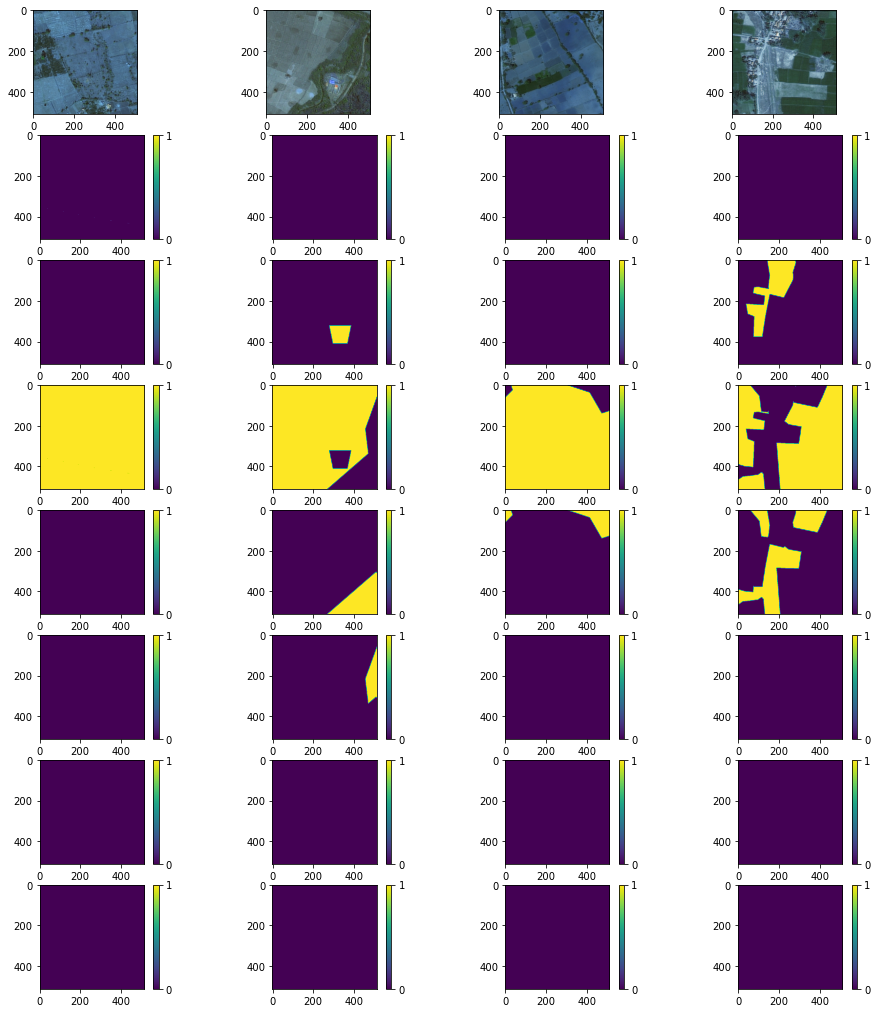

In [76]:
fig, axes = plt.subplots(8, 4, figsize=(16, 18))
# fig.subplots_adjust(hspace=0.1)
batch = 20
for a in np.arange(0,4):
    
    image = train_generator[batch][0][a+5,:,:,:]

    # Load masks
    mask = train_generator[batch][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    
    for i in range(mask.shape[2]):
        r = axes[i+1, a].imshow(mask[:,:,i], vmin = 0, vmax = 1)
        cbar = fig.colorbar(r, ax = axes[i+1, a], ticks=[0,1])
#         d.clim(0,1)
mask.shape

In [42]:
train_generator[5][1][a+5,:,:,:].shape

(512, 512, 7)

In [61]:
mask[:,:,4].max()

1.0

In [62]:
np.histogram(mask)

(array([1572864,       0,       0,       0,       0,       0,       0,
              0,       0,  262144]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))